In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

total = pd.read_csv('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/train.csv', encoding = 'cp949')
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [ ]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [ ]:
d_map = dict()
for i, d in enumerate(total['구분'].unique()):
  d_map[d] = i
# 라벨 인코딩

total['구분'] = total['구분'].map(d_map)

total

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


In [ ]:
total[total['공급량']==total['공급량'].min()]['연월일'].unique()
#total.iloc[2229:]

# 이슈
# min값이 수상함 이거 수정하고 이상치 값 수정
# 13년 8월 -> 14,15,16,17년의 평균값으로 대치
# max값은 음.. 이것도 하나하나찔러보자
# 아니면 isolation forest 돌리는데 이것도 문제있으면 좀...
# 바로 수작업

array(['2013-08-12', '2013-08-13', '2013-08-14', '2013-08-15',
       '2013-08-16', '2013-08-17', '2013-08-18', '2013-08-19',
       '2013-08-20', '2013-08-21', '2013-08-22', '2013-08-23',
       '2013-08-24', '2013-08-25', '2013-08-26', '2013-08-27',
       '2013-08-28', '2013-08-29', '2013-08-30', '2013-08-31',
       '2013-09-01', '2013-09-02', '2014-04-21', '2014-04-22',
       '2014-04-23', '2014-04-24', '2014-04-25', '2014-04-26',
       '2014-04-27', '2014-04-28', '2014-04-29', '2014-04-30',
       '2014-05-01', '2014-05-02', '2014-05-03', '2014-05-04',
       '2014-05-05', '2014-05-06', '2014-05-07', '2014-05-08',
       '2014-12-09', '2014-12-10', '2014-12-11', '2015-05-12',
       '2015-05-13', '2015-05-14', '2015-05-15', '2015-05-16',
       '2015-05-17', '2015-05-18', '2015-05-19', '2015-05-20',
       '2015-05-21', '2015-05-22', '2015-05-23', '2015-05-24',
       '2015-05-25', '2015-05-26', '2015-05-27', '2015-05-28',
       '2016-05-09', '2016-05-10', '2016-05-11', '2016-

In [ ]:
total['연월일'] = pd.to_datetime(total['연월일'])

total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

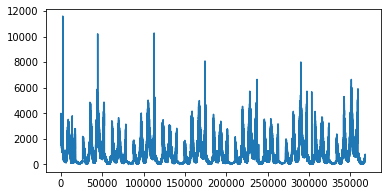

In [ ]:
f, ax = plt.subplots(figsize = (6,3))
total['공급량'].plot()

- 시계열 데이터라 그런지 뭔가 일정한 패턴이 있어보인다.

In [ ]:
import os

os.chdir('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발')

for lists in os.listdir():
  if lists[5:9]=='2013' or lists[5:9]=='2014' or lists[5:9]=='2015' or lists[5:9]=='2016' or lists[5:9]=='2017' or lists[5:9]=='2018' or lists[5:9]=='2019':
    datas = pd.read_csv(lists, encoding = 'euc-kr')
    datas = datas[['기온(°C)', '풍속(m/s)','강수량(mm)', '적설(cm)']]

    globals()['temp_{}'.format(lists[5:9])] = datas

total_temp = pd.DataFrame()
temp = [temp_2013, temp_2014, temp_2015, temp_2016, temp_2017, temp_2018]

# 시계열 결측치 보간
# 기온은 value값으로 보간 사용
# 나머지 것들은 측정되지 않은 값이므로 0으로 채워도 상관없을듯함
for i in temp:
  i['기온(°C)'] = i['기온(°C)'].interpolate(method = 'values')
  i = i.fillna(0)
  total_temp = pd.concat([total_temp, i])

for i in range(7):
  globals()['total_gu_{}'.format(i)] = total[total['구분']==i]
lists = [total_gu_0, total_gu_1, total_gu_2, total_gu_3, total_gu_4, total_gu_5, total_gu_6]

total_temps = pd.DataFrame()

for j in lists:
  s = pd.concat([j.reset_index(drop = True), total_temp.reset_index(drop = True)], axis = 1)
  total_temps = pd.concat([total_temps.reset_index(drop = True), s.reset_index(drop = True)], axis = 0)


# 날씨 부분에 null값이 있어서 그것을 먼저 해결
# 기온 부분만 해결하고 나머지 부분은 없는부분이니 0으로 채워도 무방할듯함

In [ ]:
total_temps.isnull().sum()

연월일        0
시간         0
구분         0
공급량        0
year       0
month      0
day        0
weekday    0
기온(°C)     0
풍속(m/s)    0
강수량(mm)    0
적설(cm)     0
dtype: int64

In [ ]:
train_years = [2013, 2014, 2015, 2016, 2017]
val_years = [2018] # 시계열 데이터이므로 2018년 1년치의 데이터를 예측, test data set에는 2019년 데이터를 예측

train = total_temps[total_temps['year'].isin(train_years)]
val = total_temps[total_temps['year'].isin(val_years)]

In [ ]:
print('초과 이상치 ',train[train['공급량']>=7000]['구분'].unique())
print('미만 이상치 ',train[train['공급량']<=3]['구분'].unique())
# 이상치 값을 추출하고 평년 공급량으로 맞출예정

초과 이상치  [0 5]
미만 이상치  [2 6]


In [ ]:
print('미만 이상치_val', val[val['공급량']<=3]['구분'].unique())

미만 이상치_val [2]


구분에 2번 공급처는 건드리면 안될거같고 <br>
나머지 것들만 정리를 해보겠다.

In [ ]:
outlier_index = train[train['공급량']>=7000].index
train.iloc[outlier_index]

,연월일,시간,구분,공급량,year,month,day,weekday,기온(°C),풍속(m/s),강수량(mm),적설(cm)
2230,2013-04-03,23,0,11593.617,2013,4,3,2,7.3,2.8,0.0,0.0
623,2013-01-26,24,6,616.988,2013,1,26,5,-9.3,2.3,0.0,0.0
16367,2014-11-13,24,6,375.476,2014,11,13,3,-1.0,0.9,0.0,0.0
25285,2015-11-20,14,6,206.244,2015,11,20,4,12.3,1.9,0.0,0.0
35929,2017-02-06,2,6,322.980,2017,2,6,0,-1.8,2.9,0.0,0.0


In [ ]:
train.replace(train.iloc[outlier_index[0]]['공급량'], train.query("month==4 and day==3 and year!=2013 and 시간==23 and 구분==0")['공급량'].mean(), inplace = True)
train.replace(train.iloc[outlier_index[1]]['공급량'], train.query("month==1 and day==27 and year!=2013 and 시간==24 and 구분==5")['공급량'].mean(), inplace = True)
train.replace(train.iloc[outlier_index[2]]['공급량'], train.query("month==11 and day==14 and year!=2014 and 시간==24 and 구분==5")['공급량'].mean(), inplace = True)
train.replace(train.iloc[outlier_index[3]]['공급량'], train.query("month==11 and day==21 and year!=2015 and 시간==14 and 구분==5")['공급량'].mean(), inplace = True)
train.replace(train.iloc[outlier_index[4]]['공급량'], train.query("month==2 and day==7 and year!=2017 and 시간==2 and 구분==5")['공급량'].mean(),inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
def outliter_fill(num, data):
  if num>=1000:
    outlier_index = data[data['공급량']>=num].index
  else:
    outlier_index = data[data['공급량']<=num].index

  df = data.iloc[outlier_index]

  for number in range(len(outlier_index)):
    s = data.iloc[outlier_index[i]]
    data.replace(s['공급량'], data.query("month==" + str(s['month'] + 
                                                      " and day==" + str(s['day']) + 
                                                      " and year!=" + str(s['year']) + 
                                                      " and 시간==" + str(s['시간']) + 
                                                      " and 구분==" + str(s['구분'])['공급량'].mean(), inplace = True)))

  return s

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

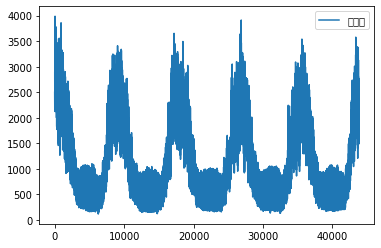

In [ ]:
train[train['구분']==0][['공급량']].reset_index(drop = True).plot()

In [ ]:
# Isolation Forest

"""total[total['구분']==0]

from sklearn.ensemble import IsolationForest

outliers = []
isolation_forest =  IsolationForest(contamination = 0.004)
for i in range(7):
  isolation_forest.fit(total[total['구분']==i][['공급량']])
  outliers.append(isolation_forest.predict(total[['공급량']]))
"""


"total[total['구분']==0]\n\nfrom sklearn.ensemble import IsolationForest\n\noutliers = []\nisolation_forest =  IsolationForest(contamination = 0.004)\nfor i in range(7):\n  isolation_forest.fit(total[total['구분']==i][['공급량']])\n  outliers.append(isolation_forest.predict(total[['공급량']]))\n"

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaler_num = ['scaler_0','scaler_1','scaler_2','scaler_3','scaler_4','scaler_5','scaler_6']

for i in range(7):
  #scaler = MinMaxScaler()
  
  scaler_num[i] = MinMaxScaler()
  globals()['train_{}'.format(i)] = scaler_num[i].fit_transform(train[train['구분']==i][['공급량','기온(°C)', '풍속(m/s)', '강수량(mm)','적설(cm)']].reset_index(drop = True))
  globals()['val_{}'.format(i)] = scaler_num[i].transform(val[val['구분']==i][['공급량','기온(°C)', '풍속(m/s)', '강수량(mm)','적설(cm)']].reset_index(drop = True))
  

print(train_0.shape, val_0.shape)

(43824, 5) (8760, 5)


In [ ]:
scaler_num[0].inverse_transform(train_0)

array([[ 2.497129e+03, -8.300000e+00,  3.600000e+00,  0.000000e+00,
         6.400000e+00],
       [ 2.363265e+03, -8.500000e+00,  4.000000e+00,  0.000000e+00,
         6.400000e+00],
       [ 2.258505e+03, -8.400000e+00,  4.000000e+00,  0.000000e+00,
         6.400000e+00],
       ...,
       [ 2.054192e+03, -1.600000e+00,  1.000000e+00,  0.000000e+00,
         0.000000e+00],
       [ 1.981397e+03, -2.100000e+00,  1.700000e+00,  0.000000e+00,
         0.000000e+00],
       [ 1.897268e+03, -2.600000e+00,  6.000000e-01,  0.000000e+00,
         0.000000e+00]])

- 딥러닝을 사용할 예정이라서 전체 데이터를 전부 넣어도 무방하지만 모델을 더 돌려보자는 취지에서 각 구분별로 모델정의 즉, 7개의 모델을 생성예정
- 그에 따라 스케일러도 7개 생성

In [ ]:
def create_dataset (X, look_back = 1):
    Xs, ys, rem_data = [], [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back][0])
        rem_data.append(X[i+look_back][1:])
 
    return np.array(Xs), np.array(ys), np.array(rem_data)

LOOK_BACK = 24

x_train_0, y_train_0, re_y_train_0 = create_dataset(train_0, LOOK_BACK)
x_val_0, y_val_0, re_y_val_0 = create_dataset(val_0, LOOK_BACK)

#################################################################

x_train_1, y_train_1, re_y_train_1 = create_dataset(train_1, LOOK_BACK)
x_val_1, y_val_1, re_y_val_1 = create_dataset(val_1, LOOK_BACK)

#################################################################

x_train_2, y_train_2, re_y_train_2 = create_dataset(train_2, LOOK_BACK)
x_val_2, y_val_2, re_y_val_2 = create_dataset(val_2, LOOK_BACK)

#################################################################

x_train_3, y_train_3, re_y_train_3 = create_dataset(train_3, LOOK_BACK)
x_val_3, y_val_3, re_y_val_3 = create_dataset(val_3, LOOK_BACK)

#################################################################

x_train_4, y_train_4, re_y_train_4 = create_dataset(train_4, LOOK_BACK)
x_val_4, y_val_4, re_y_val_4 = create_dataset(val_4, LOOK_BACK)

#################################################################

x_train_5, y_train_5, re_y_train_5 = create_dataset(train_5, LOOK_BACK)
x_val_5, y_val_5, re_y_val_5 = create_dataset(val_5, LOOK_BACK)

#################################################################

x_train_6, y_train_6, re_y_train_6 = create_dataset(train_6, LOOK_BACK)
x_val_6, y_val_6, re_y_val_6 = create_dataset(val_6, LOOK_BACK)

- LOOKBACK을 24로 정하고(시간단위 데이터인데 24시간마다 어떠한 주기가 나타날 것이라고 추측) 데이터변형

In [ ]:
from tensorflow.python.keras.callbacks import History
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, GRU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


def create_bilstm(units, x_train):
  inputs = Input(shape = (x_train.shape[1], x_train.shape[2]))
  hidden1 = Bidirectional(LSTM(units = units, return_sequences=True))(inputs)
  hidden2 = Bidirectional(LSTM(units = units))(hidden1)
  output = Dense(1)(hidden2)
  model = Model(inputs = inputs, outputs = output)
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_absolute_error'])

  return model

def create_gru(units, x_train):
  inputs = Input(shape = (x_train.shape[1], x_train.shape[2]))
  hidden1 = GRU(units = units, return_sequences=True)(inputs)
  hidden2 = GRU(units = units)(hidden1)
  output = Dense(1)(hidden2)
  model = Model(inputs = inputs, outputs = output)
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_absolute_percentage_error'])

  return model


def fit_model(model,x_train, y_train, epoch, x_val,y_val):
  early_stop = EarlyStopping(monitor = 'val_loss',
                             patience = 7)
  
  history = model.fit(x_train, y_train, 
                      epochs = epoch, 
                      validation_data = (x_val, y_val),
                      batch_size = 64,
                      shuffle = False,
                      callbacks = [early_stop])
  return history



- 양방향 LSTM, GRU를 비교할 예정

In [ ]:
from sklearn.metrics import mean_squared_error

def mape(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 


# train_0 학습
model_lstm_0 = create_bilstm(64, x_train_0)
history_lstm_0 = fit_model(model_lstm_0, x_train_0, y_train_0, 50, x_val_0, y_val_0)


pred_lstm_0 = model_lstm_0.predict(x_val_0) # 2018년 예측
re_y_val_0 = np.insert(re_y_val_0, 0, pred_lstm_0.T, axis = 1) # min-max inverse transform을 하기위한 전처리
pred_lstm_0 = scaler_num[0].inverse_transform(re_y_val_0) # inverse transform


re_y_val_0 = np.delete(re_y_val_0,0,1)
re_y_val_0 = np.insert(re_y_val_0, 0, y_val_0.T, axis = 1)

y_val_0 = scaler_num[0].inverse_transform(re_y_val_0)

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_0.T[0], y_val_0.T[0])**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_0.T[0],  y_val_0.T[0])))

Epoch 1/50
685/685 [==============================] - 63s 70ms/step - loss: 0.0047 - mean_absolute_error: 0.0450 - val_loss: 0.0021 - val_mean_absolute_error: 0.0406
Epoch 2/50
685/685 [==============================] - 44s 64ms/step - loss: 8.1684e-04 - mean_absolute_error: 0.0204 - val_loss: 9.6644e-04 - val_mean_absolute_error: 0.0245
Epoch 3/50
685/685 [==============================] - 45s 66ms/step - loss: 6.6093e-04 - mean_absolute_error: 0.0183 - val_loss: 9.3022e-04 - val_mean_absolute_error: 0.0250
Epoch 4/50
685/685 [==============================] - 43s 62ms/step - loss: 5.8469e-04 - mean_absolute_error: 0.0172 - val_loss: 7.7223e-04 - val_mean_absolute_error: 0.0223
Epoch 5/50
685/685 [==============================] - 43s 62ms/step - loss: 5.4221e-04 - mean_absolute_error: 0.0166 - val_loss: 6.2366e-04 - val_mean_absolute_error: 0.0189
Epoch 6/50
685/685 [==============================] - 43s 63ms/step - loss: 4.9568e-04 - mean_absolute_error: 0.0158 - val_loss: 5.3986e-0

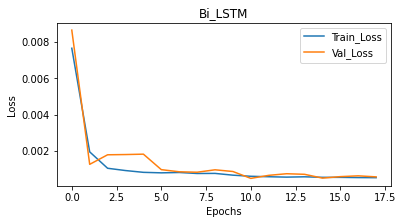

In [ ]:
def loss_vis(history, model_name):
  f, ax = plt.subplots(figsize = (6, 3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train_Loss', 'Val_Loss'])
  plt.title(model_name)

loss_vis(history_lstm_0, 'Bi_LSTM')

In [ ]:
def pred_vis(pred_model, model_name, y_val):
  f, ax = plt.subplots(figsize = (15,8))
  plt.plot(pred_model, label = 'Prediction',  alpha = 0.5)
  plt.plot(y_val, label = 'Val_data',  alpha = 0.3)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.title(model_name)


In [ ]:
# train_1 학습
model_1 = create_bilstm(64, x_train_1)
history_lstm_1 = fit_model(model_1, x_train_1, y_train_1, 70, x_val_1, y_val_1)
print('-'*150)

pred_lstm_1 = model_1.predict(x_val_1) # 2018년 예측
re_y_val_1 = np.insert(re_y_val_1, 0, pred_lstm_1.T, axis = 1) # min-max inverse transform을 하기위한 전처리
pred_lstm_1 = scaler_num[1].inverse_transform(re_y_val_1) # inverse transform


re_y_val_1 = np.delete(re_y_val_1,0,1)
re_y_val_1 = np.insert(re_y_val_1, 0, y_val_1.T, axis = 1)

y_val_1 = scaler_num[1].inverse_transform(re_y_val_1)

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_1.T[0], y_val_1.T[0])**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_1.T[0],  y_val_1.T[0])))
print('-'*150)

# train_2 학습
model_2 = create_bilstm(64, x_train_2)
history_lstm_2 = fit_model(model_2, x_train_2, y_train_2, 70, x_val_2, y_val_2)
print('-'*150)

pred_lstm_2 = model_2.predict(x_val_2) # 2018년 예측
re_y_val_2 = np.insert(re_y_val_2, 0, pred_lstm_2.T, axis = 1) # min-max inverse transform을 하기위한 전처리
pred_lstm_2 = scaler_num[2].inverse_transform(re_y_val_2) # inverse transform


re_y_val_2 = np.delete(re_y_val_2,0,1)
re_y_val_2 = np.insert(re_y_val_2, 0, y_val_2.T, axis = 1)

y_val_2 = scaler_num[2].inverse_transform(re_y_val_2)

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_2.T[0], y_val_2.T[0])**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_2.T[0],  y_val_2.T[0])))
print('-'*150)

# train_3 학습
model_3 = create_bilstm(64, x_train_3)
history_lstm_3 = fit_model(model_3, x_train_3, y_train_3, 70, x_val_3, y_val_3)
print('-'*150)

pred_lstm_3 = model_3.predict(x_val_3) # 2018년 예측
re_y_val_3 = np.insert(re_y_val_3, 0, pred_lstm_3.T, axis = 1) # min-max inverse transform을 하기위한 전처리
pred_lstm_3 = scaler_num[3].inverse_transform(re_y_val_3) # inverse transform


re_y_val_3 = np.delete(re_y_val_3,0,1)
re_y_val_3 = np.insert(re_y_val_3, 0, y_val_3.T, axis = 1)

y_val_3 = scaler_num[3].inverse_transform(re_y_val_3)

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_3.T[0], y_val_3.T[0])**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_3.T[0],  y_val_3.T[0])))
print('-'*150)

Epoch 1/70
685/685 [==============================] - 61s 68ms/step - loss: 0.0044 - mean_absolute_error: 0.0420 - val_loss: 0.0021 - val_mean_absolute_error: 0.0385
Epoch 2/70
685/685 [==============================] - 51s 75ms/step - loss: 9.1337e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0015 - val_mean_absolute_error: 0.0329
Epoch 3/70
685/685 [==============================] - 44s 64ms/step - loss: 6.7194e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0017 - val_mean_absolute_error: 0.0359
Epoch 4/70
685/685 [==============================] - 45s 65ms/step - loss: 6.3383e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0015 - val_mean_absolute_error: 0.0335
Epoch 5/70
685/685 [==============================] - 44s 65ms/step - loss: 5.8104e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0013 - val_mean_absolute_error: 0.0320
Epoch 6/70
685/685 [==============================] - 46s 67ms/step - loss: 5.3763e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0012 - val_mean_absolut

In [ ]:
# train_4 학습
model_4 = create_bilstm(64, x_train_4)
history_lstm_4 = fit_model(model_4, x_train_4, y_train_4, 50, x_val_4, y_val_4)

print('-'*150)
pred_lstm_4 = model_4.predict(x_val_4) # 2018년 예측
re_y_val_4 = np.insert(re_y_val_4, 0, pred_lstm_4.T, axis = 1) # min-max inverse transform을 하기위한 전처리
pred_lstm_4 = scaler_num[4].inverse_transform(re_y_val_4) # inverse transform


re_y_val_4 = np.delete(re_y_val_4,0,1)
re_y_val_4 = np.insert(re_y_val_4, 0, y_val_4.T, axis = 1)

y_val_4 = scaler_num[4].inverse_transform(re_y_val_4)

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_4.T[0], y_val_4.T[0])**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_4.T[0],  y_val_4.T[0])))
print('-'*150)



# train_5 학습
model_5 = create_bilstm(64, x_train_5)
history_lstm_5 = fit_model(model_5, x_train_5, y_train_5, 50, x_val_5, y_val_5)

print('-'*150)
pred_lstm_5 = model_5.predict(x_val_5) # 2018년 예측
re_y_val_5 = np.insert(re_y_val_5, 0, pred_lstm_5.T, axis = 1) # min-max inverse transform을 하기위한 전처리
pred_lstm_5 = scaler_num[5].inverse_transform(re_y_val_5) # inverse transform


re_y_val_5 = np.delete(re_y_val_5,0,1)
re_y_val_5 = np.insert(re_y_val_5, 0, y_val_5.T, axis = 1)

y_val_5 = scaler_num[5].inverse_transform(re_y_val_5)

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_5.T[0], y_val_5.T[0])**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_5.T[0],  y_val_5.T[0])))
print('-'*150)


# train_6 학습
model_6 = create_bilstm(64, x_train_6)
history_lstm_6 = fit_model(model_6, x_train_6, y_train_6, 50, x_val_6, y_val_6)
print('-'*150)

pred_lstm_6 = model_6.predict(x_val_6) # 2018년 예측
re_y_val_6 = np.insert(re_y_val_6, 0, pred_lstm_6.T, axis = 1) # min-max inverse transform을 하기위한 전처리
pred_lstm_6 = scaler_num[6].inverse_transform(re_y_val_6) # inverse transform


re_y_val_6 = np.delete(re_y_val_6,0,1)
re_y_val_6 = np.insert(re_y_val_6, 0, y_val_6.T, axis = 1)

y_val_6 = scaler_num[6].inverse_transform(re_y_val_6)

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_6.T[0], y_val_6.T[0])**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_6.T[0],  y_val_6.T[0])))
print('-'*150)


Epoch 1/50
685/685 [==============================] - 64s 73ms/step - loss: 0.0081 - mean_absolute_error: 0.0581 - val_loss: 0.0318 - val_mean_absolute_error: 0.1602
Epoch 2/50
685/685 [==============================] - 49s 71ms/step - loss: 0.0014 - mean_absolute_error: 0.0267 - val_loss: 0.0080 - val_mean_absolute_error: 0.0795
Epoch 3/50
685/685 [==============================] - 48s 70ms/step - loss: 6.2455e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0049 - val_mean_absolute_error: 0.0616
Epoch 4/50
685/685 [==============================] - 46s 68ms/step - loss: 5.6681e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0026 - val_mean_absolute_error: 0.0457
Epoch 5/50
685/685 [==============================] - 46s 67ms/step - loss: 5.4780e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0017 - val_mean_absolute_error: 0.0356
Epoch 6/50
685/685 [==============================] - 45s 66ms/step - loss: 5.1239e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0013 - val_mean_absolute_er

In [ ]:
model_list = [model_lstm_0, model_1, model_2, model_3, model_4, model_5, model_6]
num = 0
for i in model_list:
  i.save('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/' + 'model_' + str(num)+'_0711_2' + '.h5')
  num+=1

- 코랩 무료 gpu의 한계로 모델을 저장하고 불러오는 방법 선택

In [ ]:
from tensorflow.keras.models import load_model
model_list = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']
num = 0

for i in model_list:
  globals()['{}'.format(i)] = load_model('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/' + 'model_' + str(num)+'_0711_2'+'.h5')
  num+=1


In [ ]:
from sklearn.metrics import mean_squared_error

def mape(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

y_val_0 = scaler_num[0].inverse_transform(y_val_0)
pred_lstm_0 = scaler_num[0].inverse_transform(model_0.predict(x_val_0))

print('RMSE : {}'.format(mean_squared_error(y_val_0, pred_lstm_0)**0.5))

y_val_1 = scaler_num[1].inverse_transform(y_val_1)
pred_lstm_1 = scaler_num[1].inverse_transform(model_1.predict(x_val_1))

print('RMSE : {}'.format(mean_squared_error(y_val_1, pred_lstm_1)**0.5))

y_val_2 = scaler_num[2].inverse_transform(y_val_2)
pred_lstm_2 = scaler_num[2].inverse_transform(model_2.predict(x_val_2))

print('RMSE : {}'.format(mean_squared_error(y_val_2, pred_lstm_2)**0.5))

y_val_3 = scaler_num[3].inverse_transform(y_val_3)
pred_lstm_3 = scaler_num[3].inverse_transform(model_3.predict(x_val_3))

print('RMSE : {}'.format(mean_squared_error(y_val_3, pred_lstm_3)**0.5))

y_val_4 = scaler_num[4].inverse_transform(y_val_4)
pred_lstm_4 = scaler_num[4].inverse_transform(model_4.predict(x_val_4))

print('RMSE : {}'.format(mean_squared_error(y_val_4, pred_lstm_4)**0.5))

y_val_5 = scaler_num[5].inverse_transform(y_val_5)
pred_lstm_5 = scaler_num[5].inverse_transform(model_5.predict(x_val_5))

print('RMSE : {}'.format(mean_squared_error(y_val_5, pred_lstm_5)**0.5))

y_val_6 = scaler_num[6].inverse_transform(y_val_6)
pred_lstm_6 = scaler_num[6].inverse_transform(model_6.predict(x_val_6))

print('RMSE : {}'.format(mean_squared_error(y_val_6, pred_lstm_6)**0.5))






In [ ]:
y_val_total = (np.concatenate((y_val_0.T[0], y_val_1.T[0], y_val_2.T[0], y_val_3.T[0], y_val_4.T[0], y_val_5.T[0], y_val_6.T[0]), axis=0))
pred_lstm_total = (np.concatenate((pred_lstm_0.T[0], pred_lstm_1.T[0], pred_lstm_2.T[0], pred_lstm_3.T[0], pred_lstm_4.T[0], pred_lstm_5.T[0], pred_lstm_6.T[0]), axis=0))

print('RMSE : {}'.format(mean_squared_error(y_val_total, pred_lstm_total)**0.5))
print('MAPE : {}'.format(mape(y_val_total, pred_lstm_total)))

RMSE : 109.67906379969284
MAPE : 25.92721708878895


- 온도를 추가하기전 lstm보다 성능이 더 안좋아졌다.
RMSE 기준 약 70이었는데 지금은 RMSE기준 109이다.


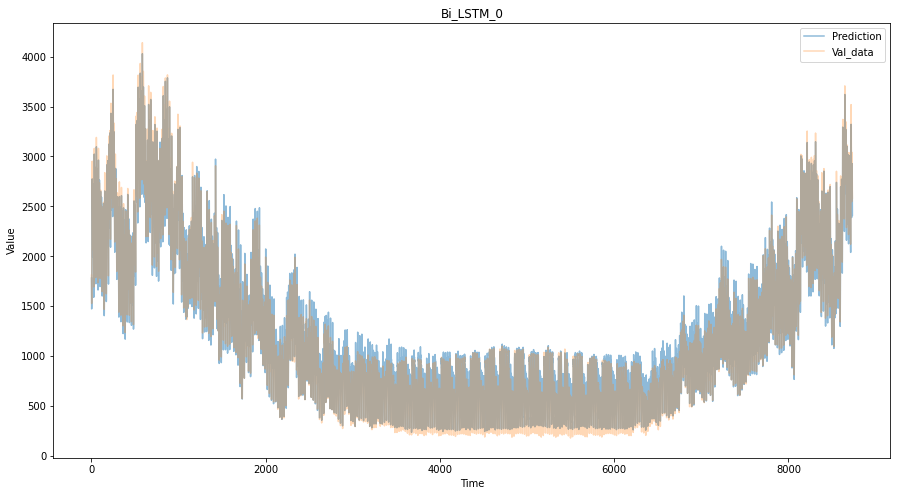

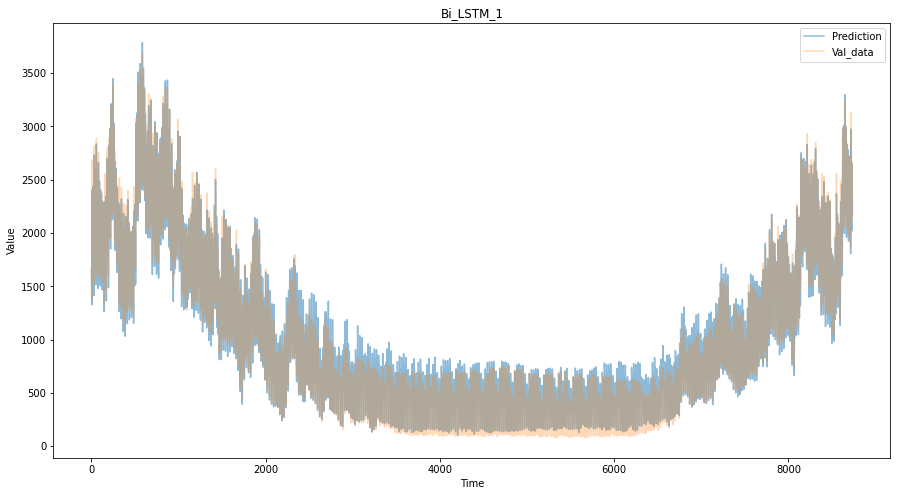

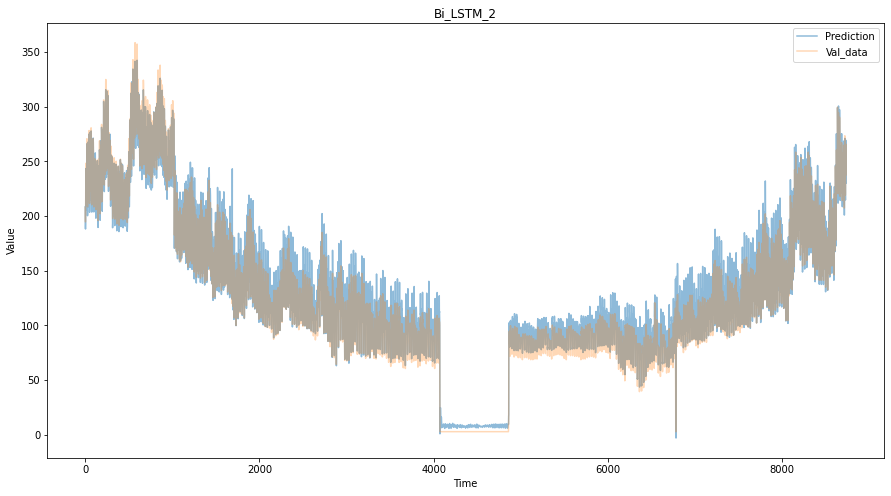

In [ ]:
pred_vis(pred_lstm_0.T[0], 'Bi_LSTM_0', y_val_0.T[0])
pred_vis(pred_lstm_1.T[0], 'Bi_LSTM_1', y_val_1.T[0])
pred_vis(pred_lstm_2.T[0], 'Bi_LSTM_2', y_val_2.T[0])

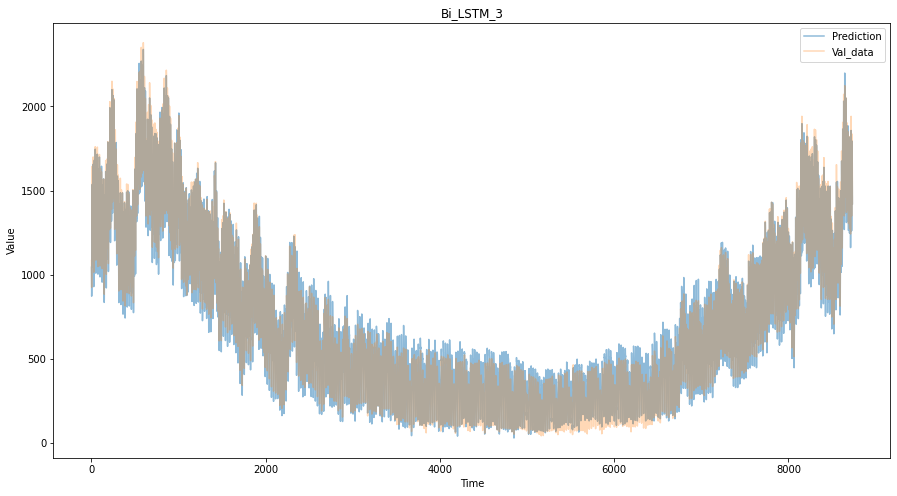

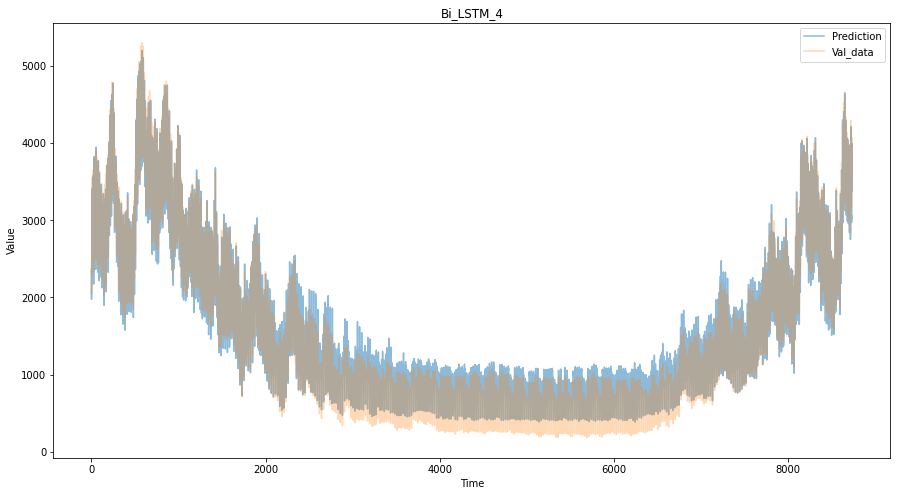

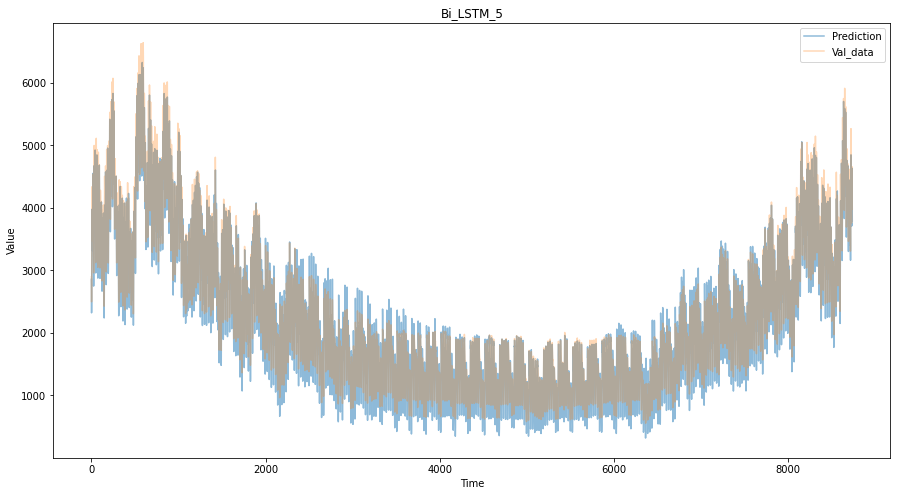

In [ ]:
pred_vis(pred_lstm_3.T[0], 'Bi_LSTM_3', y_val_3.T[0])
pred_vis(pred_lstm_4.T[0], 'Bi_LSTM_4', y_val_4.T[0])
pred_vis(pred_lstm_5.T[0], 'Bi_LSTM_5', y_val_5.T[0])

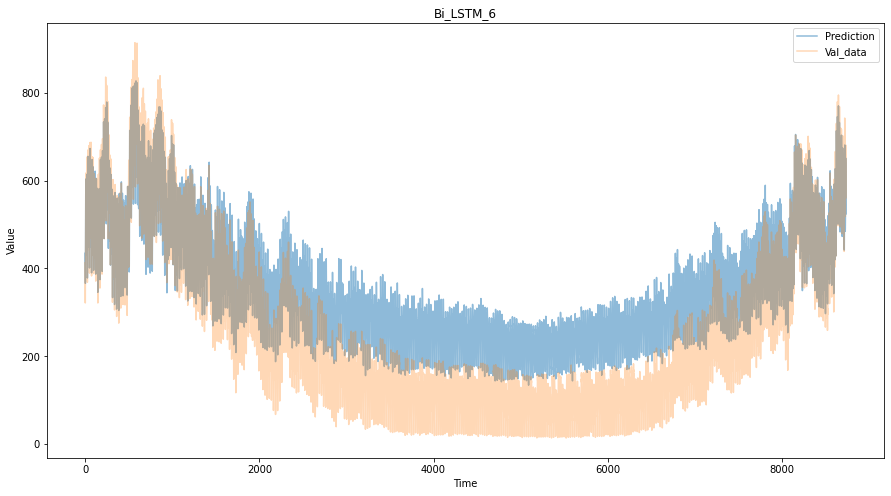

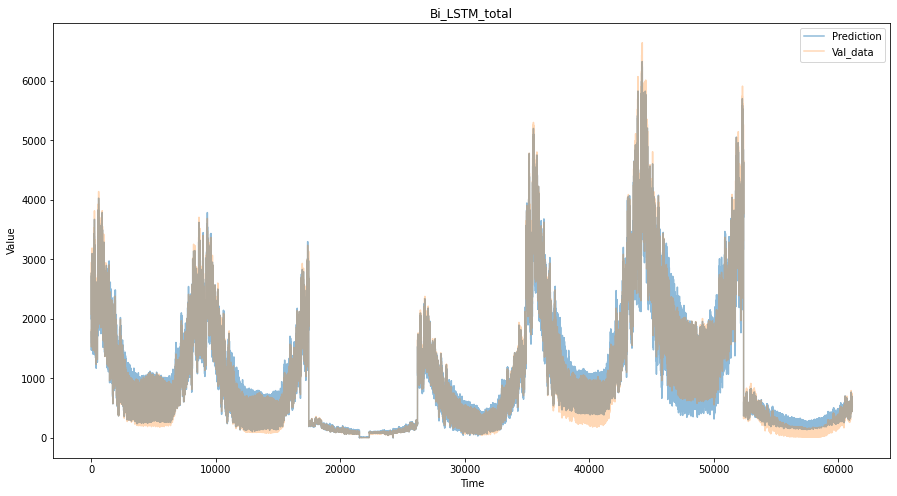

In [ ]:
pred_vis(pred_lstm_6.T[0], 'Bi_LSTM_6', y_val_6.T[0])
pred_vis(pred_lstm_total, 'Bi_LSTM_total', y_val_total)

- 온도를 추가했는데 이게 지역에 따른 온도를 다르게 추가한것이 아니라서 예측하는데 어려웠나보다.
- 노멀한 Bi LSTM보다 더 성능이 안좋다.